In [1]:
import sys
import os
import pandas as pd
import MDAnalysis as mda
from utils import utils
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import sbmlcore
from sklearn.utils import resample
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score, confusion_matrix



sys.path.append(os.path.abspath('ml-models'))
from mlmodels.Models import Models


/Users/dylanadlard/miniforge3/envs/rif_manuscript/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Data Import

### Isolate dataset (ie all matched solos)

Import solo mutations in rpoB - these are the isolates from which the ML dataframe is generated

In [2]:
solos = pd.read_csv('./data/tables/generated/rpoB_solos.csv')
solos

,UNIQUEID,GENE,MUTATION,POSITION,AMINO_ACID_NUMBER,GENOME_INDEX,NUCLEOTIDE_NUMBER,REF,ALT,IS_SNP,...,ELEMENT_TYPE,MUTATION_TYPE,INDEL_LENGTH,INDEL_1,INDEL_2,SITEID,NUMBER_NUCLEOTIDE_CHANGES,segid,resid,PHENOTYPE
0,site.02.subj.1033.lab.2013185075.iso.1,rpoB,S450L,450.0,450.0,NaN,NaN,tcg,ttg,True,...,GENE,AAM,NaN,NaN,NaN,02,1,C,450,R
1,site.02.subj.0739.lab.2013221518.iso.1,rpoB,S450L,450.0,450.0,NaN,NaN,tcg,ttg,True,...,GENE,AAM,NaN,NaN,NaN,02,1,C,450,R
2,site.02.subj.0604.lab.241032-14.iso.1,rpoB,M587I,587.0,587.0,NaN,NaN,atg,ata,True,...,GENE,AAM,NaN,NaN,NaN,02,1,C,587,S
3,site.02.subj.0104.lab.22A057.iso.1,rpoB,S450L,450.0,450.0,NaN,NaN,tcg,ttg,True,...,GENE,AAM,NaN,NaN,NaN,02,1,C,450,R
4,site.02.subj.0885.lab.22A119.iso.1,rpoB,S450L,450.0,450.0,NaN,NaN,tcg,ttg,True,...,GENE,AAM,NaN,NaN,NaN,02,1,C,450,R
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9833,site.10.subj.SATRL0116187_S19.lab.TRL0116187_S...,rpoB,S450L,450.0,450.0,NaN,NaN,tcg,ttg,True,...,GENE,AAM,NaN,NaN,NaN,10,1,C,450,R
9834,site.10.subj.SATRL0117008_S16.lab.TRL0117008_S...,rpoB,S450L,450.0,450.0,NaN,NaN,tcg,ttg,True,...,GENE,AAM,NaN,NaN,NaN,10,1,C,450,R
9835,site.10.subj.SATRL0115669_S18.lab.TRL0115669_S...,rpoB,S450L,450.0,450.0,NaN,NaN,tcg,ttg,True,...,GENE,AAM,NaN,NaN,NaN,10,1,C,450,R
9836,site.10.subj.XD01227882.lab.XD01227882.iso.1,rpoB,S450L,450.0,450.0,NaN,NaN,tcg,ttg,True,...,GENE,AAM,NaN,NaN,NaN,10,1,C,450,R


### ML dataset

The dataset used to train (and test) the models contains unique mutations - the mutation counts in the solo isolate df above is used to determine phenotypes for each mutation.

In [3]:
data = pd.read_csv('./data/tables/generated/features_dataset.csv', index_col=0)

#replace R/S labels with binary 1/0
data['phenotype'] = [1 if i =='R' else 0 for i in data.PHENOTYPE]

data

,segid,mutation,PHENOTYPE,d_volume,d_hydropathy_KD,d_MW,d_pi,d_rogov,Rif_distance,Mg_distance,...,psi,n_hbond_acceptors,n_hbond_donors,SASA,snap2_score,deep_ddG,rasp_score,temp_factor,secondary_structure,phenotype
0,C,A1002P,S,24.1,-3.4,26.0,0.30,0.020,45.415055,31.783345,...,164.84,1.0,1.0,7.268116,36,-2.927,0.800033,36.009998,0,0
1,C,A286V,R,51.4,2.4,28.0,-0.04,0.232,47.831892,64.028439,...,-17.70,0.0,1.0,0.000000,-31,-0.523,0.222401,121.500000,1,1
2,C,A29T,S,27.5,-2.5,30.0,-0.40,0.248,34.306893,40.030977,...,161.38,0.0,0.0,34.753706,-81,-1.142,0.328659,32.820000,2,0
3,C,A29V,S,51.4,2.4,28.0,-0.04,0.232,34.306893,40.030977,...,161.38,0.0,0.0,34.753706,-76,-1.056,0.284229,32.820000,2,0
4,C,A334D,S,22.5,-5.3,44.0,-3.23,0.029,43.228183,56.772771,...,-16.26,1.0,1.0,0.786252,-54,-2.734,0.369132,102.089996,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
301,C,V895F,S,49.9,-1.4,48.1,-0.48,0.345,41.296670,28.986757,...,-22.89,0.0,0.0,35.841417,-1,-1.014,0.287163,37.750000,3,0
302,C,V946G,S,-79.9,-4.6,-42.0,0.01,-0.080,53.471656,48.889279,...,122.58,0.0,0.0,86.193134,-81,-0.444,0.424508,68.440002,2,0
303,C,Y308C,R,-85.1,3.8,-60.0,-0.59,-0.199,33.128330,49.415429,...,-35.81,1.0,1.0,70.874065,68,-1.361,0.467171,76.190002,1,1
304,C,Y572C,S,-85.1,3.8,-60.0,-0.59,-0.199,37.911061,45.458752,...,172.92,1.0,1.0,27.871431,35,-1.543,0.563006,61.090000,0,0


# Some Features are more predictive than others

To get an idea of how powerful each feature is, we can generate a logisitic regression for each isolated feature in turn and measure model performance. 

In [4]:
outputs= {}
feature_list = data.columns[3:-1]
#iterate through features and train a model on that feature alone
for feat in feature_list:
    outputs[feat] =  Models({feat:data[[feat, 'phenotype']]}, 
                      "LR", "average_precision", random_seed=0, test_fraction=0.25, verbose=False, output_plots=False).returning_output(output_plots=False)

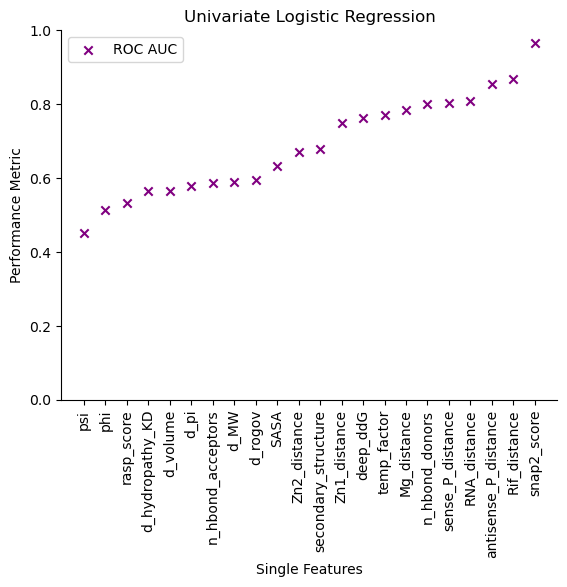

In [5]:
#plot roc_auc values for each feature's model

roc_auc = []
for key in outputs:
    key_dict = dict(outputs[key].items())
    roc_auc.append(key_dict["ROC_AUC"])

# Sort features and roc_auc values
sorted_features_roc_auc = sorted(zip(feature_list, roc_auc), key=lambda x: x[1])
sorted_feature_list, sorted_roc_auc = zip(*sorted_features_roc_auc)

# Feature order is from roc_auc from quick univariate LR in notebook 3
fig, ax = plt.subplots()
ax.scatter(sorted_feature_list, sorted_roc_auc, marker='x', label='ROC AUC', color='purple')
ax.set_xlabel('Single Features')
ax.set_ylabel('Performance Metric')
plt.xticks(rotation=90)
ax.legend() 
plt.ylim(0, 1)
ax.set_title("Univariate Logistic Regression")
sns.despine(ax=ax, top=True, right=True)

plt.savefig('./imgs/univariate_LR_metrics.png', bbox_inches='tight', dpi=600, format='png')

The most predictive feature is SNAP_2  score - this isn't surprising given SNAP2 uses a neural net trained on evolutional infromation sand strucutral features(like solvent accessibility) to predict changes to secondary structure on mutation. 

Following SNAP_2, the most predictive features are distance-based metrics. This is also unsurprising as rifampicin RAVs are typically located within the RRDR, a very well defined region in rpoB that constitutes resiudes involved in rifapicin binding:


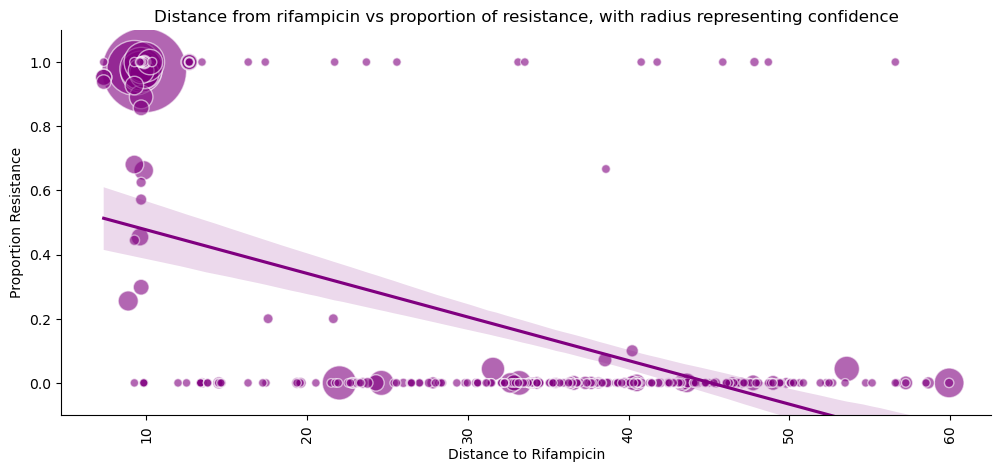

In [6]:
#cross tab our solos dataframe to get phenotype counts for each unique mutation
ct = pd.crosstab([solos.MUTATION, solos.segid, solos.resid], solos.PHENOTYPE)
ct["total"] = ct.sum(axis=1)
ct.sort_values(by='total', inplace=True, ascending=False)
ct[['proportion_R', 'ci_lower', 'ci_upper']] = ct.apply(lambda row: utils.wilson(row['R'], row['total']), axis=1, result_type='expand')
ct = ct.reset_index().rename(columns={'MUTATION':'mutation'})

# Merging ct with ML dataframe to pull out distances to rifampicin for each mutation
ct_features = pd.merge(ct, data, on=['mutation'], how='inner')
ct_features['ci_width'] = ct_features['ci_upper'] - ct_features['ci_lower']
ct_features['marker_size'] = (1 / ct_features['ci_width']) * 30  # Scale for visibility

#plot distance to rifampicin vs proportion resistance, with some measure of confidence (ie sample size) in the proportion 
fig, ax = plt.subplots(figsize=(12, 5))
sc = ax.scatter(ct_features['Rif_distance'], ct_features['proportion_R'], 
                s=ct_features['marker_size'], c='purple', alpha=0.6, edgecolors='w', label='Data points')
sns.regplot(x='Rif_distance', y='proportion_R', data=ct_features, scatter=False, color='purple', ax=ax)
ax.set_xlabel('Distance to Rifampicin')
ax.set_ylabel('Proportion Resistance')
plt.xticks(rotation=90)
plt.ylim(-0.1, 1.1)
sns.despine(ax=ax, top=True, right=True)
norm = plt.Normalize(ct_features['ci_width'].min(), ct_features['ci_width'].max())
sm = plt.cm.ScalarMappable(cmap="Purples", norm=norm)
sm.set_array([])
plt.title('Distance from rifampicin vs proportion of resistance, with radius representing confidence')
plt.savefig('./imgs/distance_vs_probR_confidence.png', bbox_inches='tight', dpi=600, format='png')
plt.show()

 Via relative positioning, distance based metrics thus allow the model to idenitify mutations that are within the RRDR and are likely to induce resistance (ie the lower the distance to rifampicin or mRNA, the greater the probability that mutation confers resistance).


RASP score, psi angles, changes in hydropathy, and changes in sioeelctirc point also return ROC AUC socres less than 0.5 - these are therefore dropped from the analysis.

In [7]:
data = data.drop(columns=['d_hydropathy_KD', 'psi', 'phi', 'rasp_score', 'd_pi'])
feature_list = data.columns[3:-1]
print ('Number of features left in our data:', len(feature_list))

Number of features left in our data: 17


# Machine learning models trained on all features are predictive 

If we just use a naive approach and include all remaining features, the model performs well:

In [8]:
models = ['LR', 'RF', 'DT', 'GBDT']
feature_set = data.columns[3:-1]
outputs = {}

for model_type in models:
    feature_data = data[feature_set].copy()
    feature_data["phenotype"] = data["phenotype"]

    model_obj = Models(
        {"all": feature_data},
        model_type,
        "average_precision",
        random_seed=0,
        test_fraction=0.25,
        verbose=False,
        output_plots=False,
    )

    model = model_obj.opt_estimator
    X_test = model_obj.X_test_nd["all"]
    y_test = model_obj.y_test_nd["all"]

    outputs[model_type] = utils.manual_bootstrap(model, X_test, y_test, 0.67, n_iterations=100)
    


In [16]:
model_obj = Models(
        {"all": feature_data},
        'LR',
        "average_precision",
        random_seed=0,
        test_fraction=0.25,
        verbose=False,
        output_plots=False,
    )

y_test = model_obj.y_test_nd["all"]
y_test


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0])

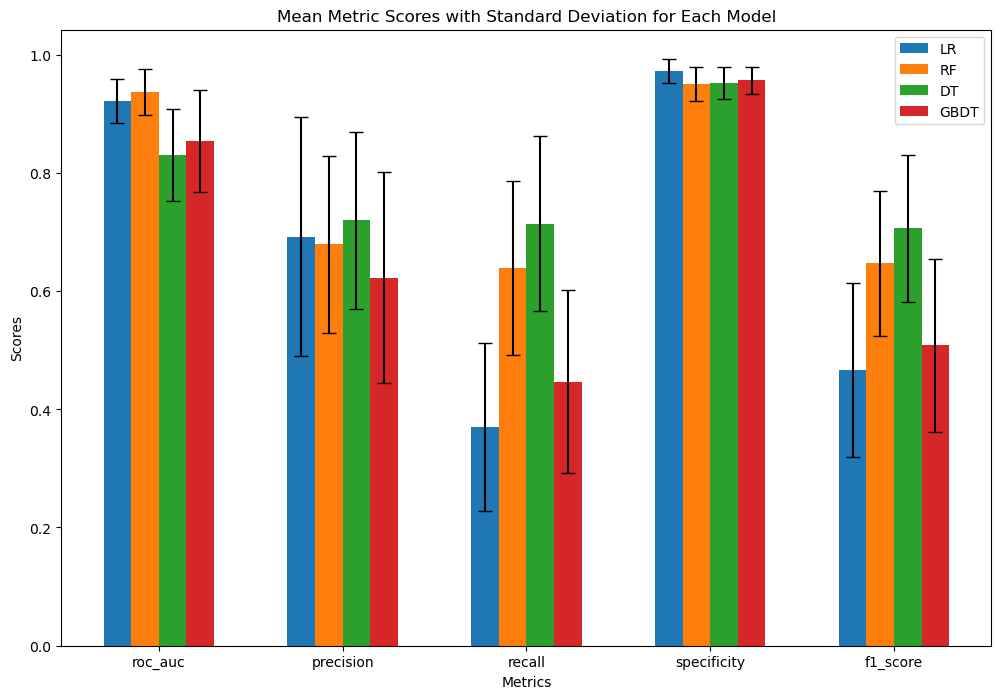

In [13]:


# Calculate mean and standard deviation for each metric
mean_metrics = {}
std_metrics = {}

for model_type, metrics in outputs.items():
    mean_metrics[model_type] = {metric: np.mean(values) for metric, values in metrics.items()}
    std_metrics[model_type] = {metric: np.std(values) for metric, values in metrics.items()}

# Metrics to plot
metric_names = ['roc_auc', 'precision', 'recall', 'specificity', 'f1_score']
model_names = list(mean_metrics.keys())
n_models = len(model_names)
n_metrics = len(metric_names)

# Positioning the bars
bar_width = 0.15
index = np.arange(n_metrics)

fig, ax = plt.subplots(figsize=(12, 8))

for i, model in enumerate(model_names):
    means = [mean_metrics[model][metric] for metric in metric_names]
    stds = [std_metrics[model][metric] for metric in metric_names]
    ax.bar(index + i * bar_width, means, bar_width, yerr=stds, capsize=5, label=model)

# Add labels, title, and legend
ax.set_xlabel('Metrics')
ax.set_ylabel('Scores')
ax.set_title('Mean Metric Scores with Standard Deviation for Each Model')
ax.set_xticks(index + bar_width * (n_models - 1) / 2)
ax.set_xticklabels(metric_names)
ax.legend()

plt.show()

